In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet

In [2]:
# Load raw datasets
stores = pd.read_csv("/content/stores.csv")
oil = pd.read_csv("/content/oil.csv")
holidays = pd.read_csv("/content/holidays_events.csv")

In [3]:
# Convert date columns
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [4]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
# Fill missing oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
# Filter national holidays
holidays = holidays[holidays['locale'] == 'National'].drop_duplicates(subset='date')

In [8]:
holidays.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [9]:
# Loading the main files
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])

In [10]:
# Merging the stores dataset based in store_nbr
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

In [11]:
# Merging the oil dataset based on date
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

In [12]:
# Merging the holidays dataset based on date
train_merged = train.merge(holidays[['date', 'type', 'description', 'transferred']],
                    on='date', how='left')
test_merged = test.merge(holidays[['date', 'type', 'description', 'transferred']],
                   on='date', how='left')

In [13]:
# Save the merged training and testing datasets into a separate CSV files
train_merged.to_csv('/content/train_merged.csv', index=False)
test_merged.to_csv('/content/test_merged.csv', index=False)


In [14]:
# Load train data
train = pd.read_csv('/content/train_merged.csv', parse_dates=['date'])

# Sort for rolling calculations
train = train.sort_values(by=['store_nbr', 'family', 'date'])

<ipython-input-14-9877cb5e0922>:2: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train_merged.csv', parse_dates=['date'])


In [15]:
# Time-based Features processing
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week.astype(int)
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)
train['is_december'] = (train['month'] == 12).astype(int)

In [16]:
# Event-based Features processing
train['is_holiday'] = train['type_y'].notna().astype(int)
train['is_payday'] = train['day'].isin([15, 28, 29, 30, 31]).astype(int)
train['earthquake_impact'] = (train['date'] == pd.to_datetime('2016-04-16')).astype(int)


In [17]:
# 7-day rolling mean and std using rolling statistics
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.rolling(7, min_periods=1).std())

# Lag features
train['lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)

In [18]:
# Avg sales per store type
avg_sales_by_type = train.groupby('type_x')['sales'].mean().reset_index()\
                         .rename(columns={'sales': 'avg_sales_by_type'})
train = train.merge(avg_sales_by_type, on='type_x', how='left')


In [19]:
# Top-selling families per cluster
top_families = train.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_families = top_families.sort_values(['cluster', 'sales'], ascending=[True, False])
top_families['rank'] = top_families.groupby('cluster')['sales'].rank(method='first', ascending=False)


In [20]:
# Flag top 3 families per cluster
top_3 = top_families[top_families['rank'] <= 3][['cluster', 'family']]
top_3['top_family_cluster'] = 1
train = train.merge(top_3, on=['cluster', 'family'], how='left')
train['top_family_cluster'] = train['top_family_cluster'].fillna(0)

In [21]:
# Save the final featured train dataset
train.to_csv('/content/train_featured.csv', index=False)
print("File saved as 'train_featured.csv'")

File saved as 'train_featured.csv'


In [22]:
# Load the featured dataset
df = pd.read_csv('/content/train_featured.csv', parse_dates=['date'])

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

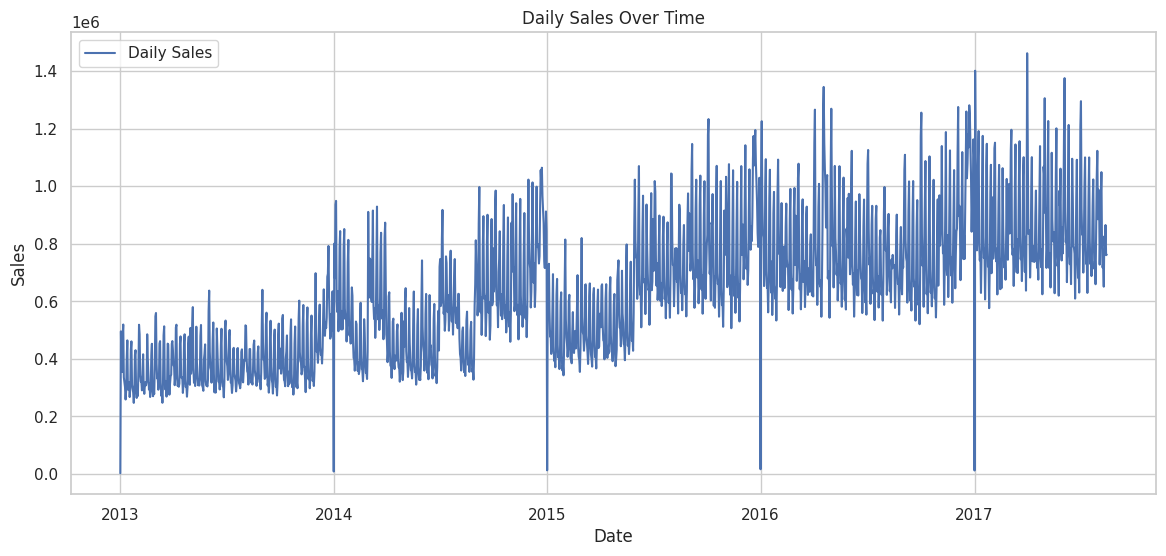

In [23]:
# Sales Trends Over Time
daily_sales = df.groupby('date')['sales'].sum().reset_index()

plt.figure()
plt.plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

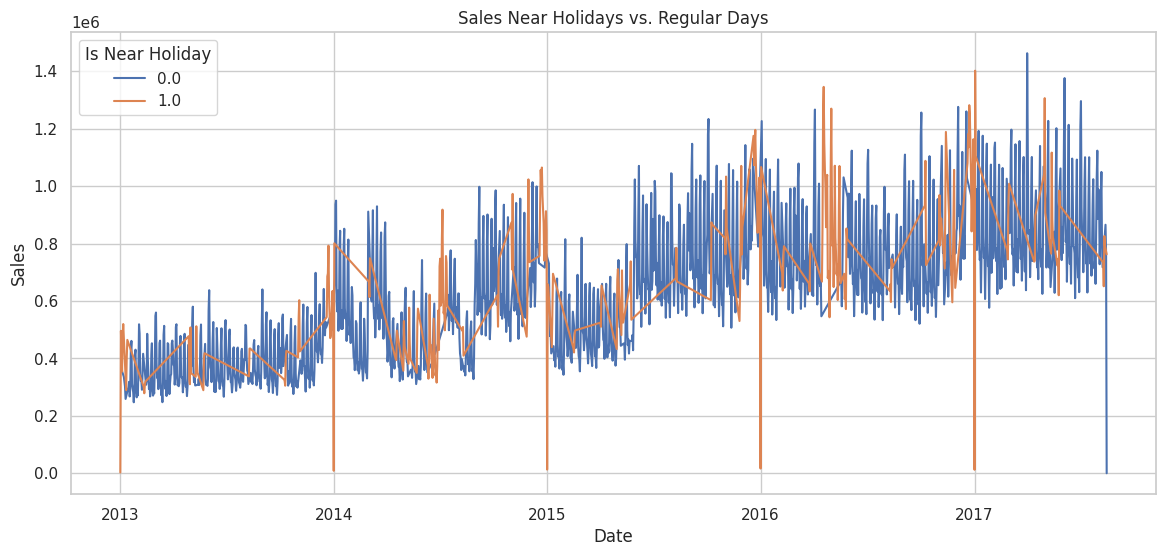

In [24]:
# Sales Before and After Holidays
df['is_near_holiday'] = df['is_holiday'].rolling(3, center=True, min_periods=1).max()

near_holiday_sales = df.groupby(['date', 'is_near_holiday'])['sales'].sum().reset_index()

plt.figure()
sns.lineplot(data=near_holiday_sales, x='date', y='sales', hue='is_near_holiday')
plt.title("Sales Near Holidays vs. Regular Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Is Near Holiday")
plt.show()

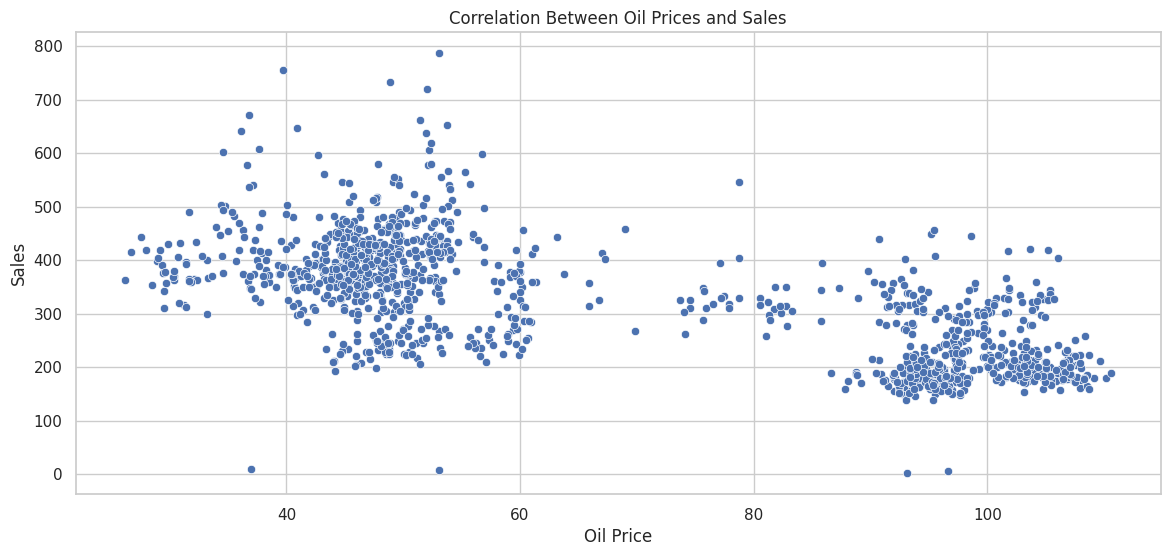

 Correlation between oil prices and sales: -0.69


In [25]:
# Correlation: Oil Prices vs. Sales
# Aggregate sales and oil by date
sales_oil = df.groupby('date')[['sales', 'dcoilwtico']].mean().reset_index()

plt.figure()
sns.scatterplot(data=sales_oil, x='dcoilwtico', y='sales')
plt.title("Correlation Between Oil Prices and Sales")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.show()

# Compute correlation coefficient
correlation = sales_oil['sales'].corr(sales_oil['dcoilwtico'])
print(f" Correlation between oil prices and sales: {correlation:.2f}")

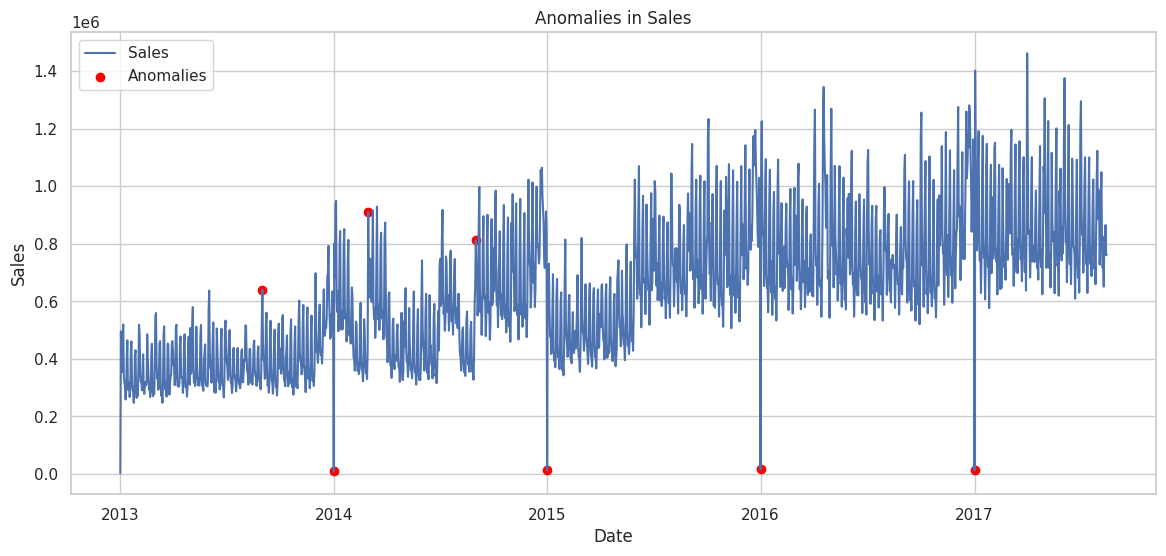

Number of anomalies found: 7


In [26]:
# Anomaly Detection (Simple)
# Calculate daily z-scores to find outliers
daily_sales['mean'] = daily_sales['sales'].rolling(30, min_periods=1).mean()
daily_sales['std'] = daily_sales['sales'].rolling(30, min_periods=1).std()
daily_sales['z_score'] = (daily_sales['sales'] - daily_sales['mean']) / daily_sales['std']

# Flag anomalies: z-score > 3 or < -3
anomalies = daily_sales[(daily_sales['z_score'].abs() > 3)]

plt.figure()
plt.plot(daily_sales['date'], daily_sales['sales'], label='Sales')
plt.scatter(anomalies['date'], anomalies['sales'], color='red', label='Anomalies')
plt.title("Anomalies in Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

print(f"Number of anomalies found: {len(anomalies)}")

In [27]:
# LOAD AND PREP DATA
df = pd.read_csv('/content/train_featured.csv', parse_dates=['date'])

# Focus on one series
df_one = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')].copy()
df_one = df_one.set_index('date').sort_index()

In [28]:
# Fill missing dates & interpolate sales
date_range = pd.date_range(df_one.index.min(), df_one.index.max(), freq='D')
df_one = df_one.reindex(date_range)
df_one[['store_nbr', 'family', 'type_x', 'cluster']] = df_one[['store_nbr', 'family', 'type_x', 'cluster']].fillna(method='ffill')
df_one['sales'] = df_one['sales'].interpolate(method='linear', limit_direction='both')
df_one = df_one.reset_index().rename(columns={'index': 'date'})


<ipython-input-28-9bfeaa07e2c9>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_one[['store_nbr', 'family', 'type_x', 'cluster']] = df_one[['store_nbr', 'family', 'type_x', 'cluster']].fillna(method='ffill')


In [29]:
# Features
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_weekend',
            'is_holiday', 'is_payday', 'rolling_mean_7', 'lag_7', 'lag_30']

In [30]:
# Train, test split
train_df = df_one[:-15]
test_df = df_one[-15:]
y_train = train_df['sales']
y_test = test_df['sales']
X_train = train_df[features].fillna(0)
X_test = test_df[features].fillna(0)

In [31]:
# EVALUATION FUNCTION
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f" {name}")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAPE: {mape:.2%}")
    print(f" - R²: {r2:.4f}\n")
    return {'Model': name, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

results_list = []

In [32]:
#  Naive
naive_pred = [y_train.iloc[-1]] * len(y_test)
results_list.append(evaluate_model(y_test, naive_pred, "Naive"))

 Naive
 - RMSE: 1000.15
 - MAPE: 53.44%
 - R²: -1.0225



In [33]:
#  ARIMA
arima = ARIMA(y_train, order=(5,1,0)).fit()
arima_pred = arima.forecast(steps=15)
results_list.append(evaluate_model(y_test, arima_pred, "ARIMA"))

 ARIMA
 - RMSE: 707.53
 - MAPE: 36.73%
 - R²: -0.0121



In [34]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results_list.append(evaluate_model(y_test, rf_pred, "Random Forest"))


 Random Forest
 - RMSE: 435.22
 - MAPE: 13.46%
 - R²: 0.6170



In [35]:
#  XGBoost
xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
xgb_pred = xg.predict(X_test)
results_list.append(evaluate_model(y_test, xgb_pred, "XGBoost"))

 XGBoost
 - RMSE: 475.33
 - MAPE: 15.35%
 - R²: 0.5432



In [36]:
# LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
results_list.append(evaluate_model(y_test, lstm_pred, "LSTM"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
 LSTM
 - RMSE: 2106.38
 - MAPE: 84.94%
 - R²: -7.9706



In [37]:
#  Prophet
prophet_df = df_one[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df[:-15])
future = prophet_model.make_future_dataframe(periods=15)
forecast = prophet_model.predict(future)
prophet_pred = forecast.iloc[-15:]['yhat'].values
results_list.append(evaluate_model(y_test, prophet_pred, "Prophet"))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohp0sy2n/cw80m15z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohp0sy2n/dcryivo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5788', 'data', 'file=/tmp/tmpohp0sy2n/cw80m15z.json', 'init=/tmp/tmpohp0sy2n/dcryivo0.json', 'output', 'file=/tmp/tmpohp0sy2n/prophet_modellfolhdqr/prophet_model-20250408195547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet
 - RMSE: 511.39
 - MAPE: 22.55%
 - R²: 0.4713



In [38]:
# Combine Predictions
results_df = pd.DataFrame({
    'Date': test_df['date'].values[:15],
    'Actual': y_test.values[:15],
    'Naive': np.array(naive_pred)[:15],
    'ARIMA': np.array(arima_pred).flatten()[:15],
    'RandomForest': np.array(rf_pred)[:15],
    'XGBoost': np.array(xgb_pred)[:15],
    'LSTM': np.array(lstm_pred).flatten()[:15],
    'Prophet': np.array(prophet_pred).flatten()[:15]
})

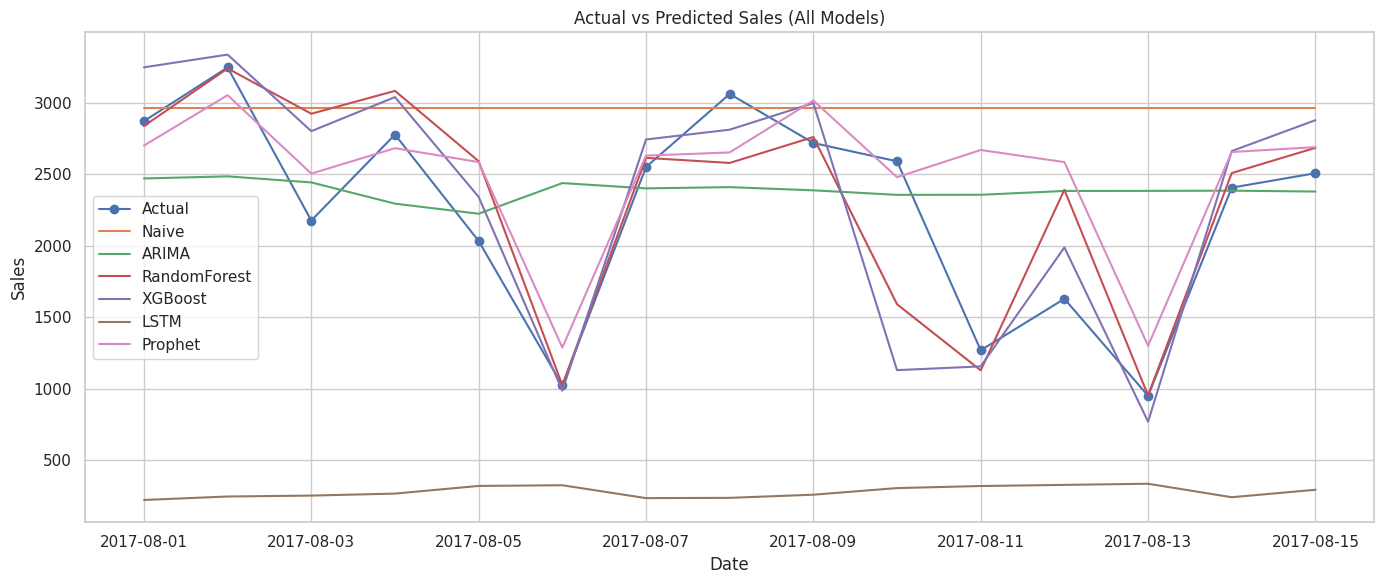

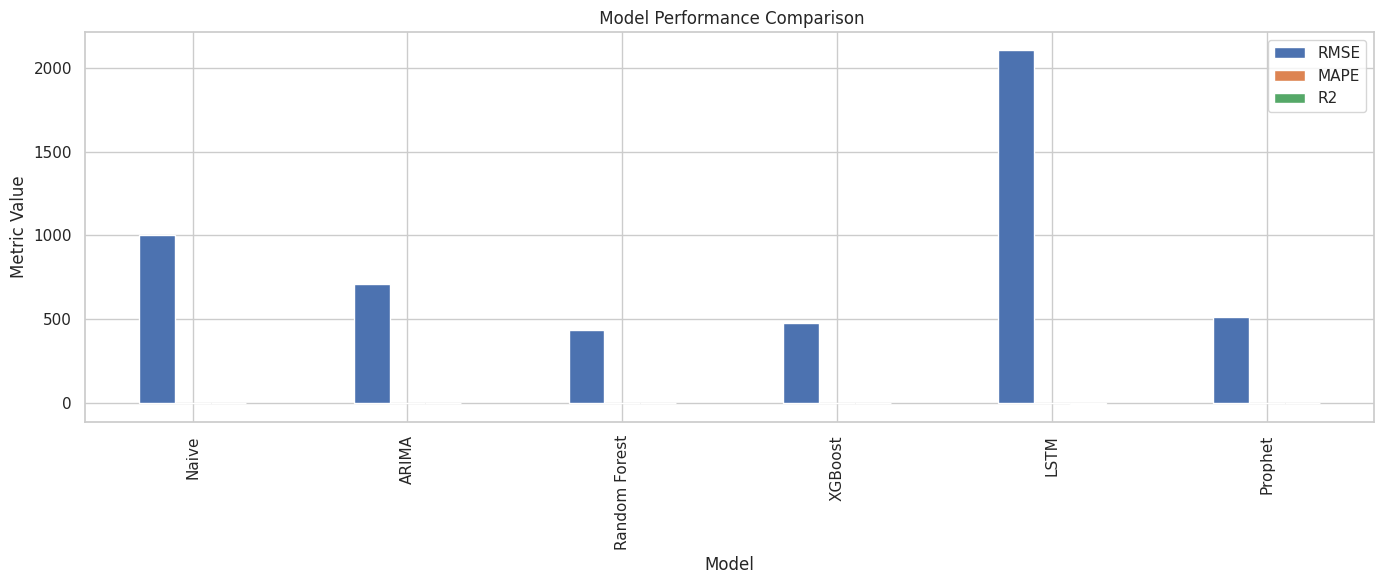

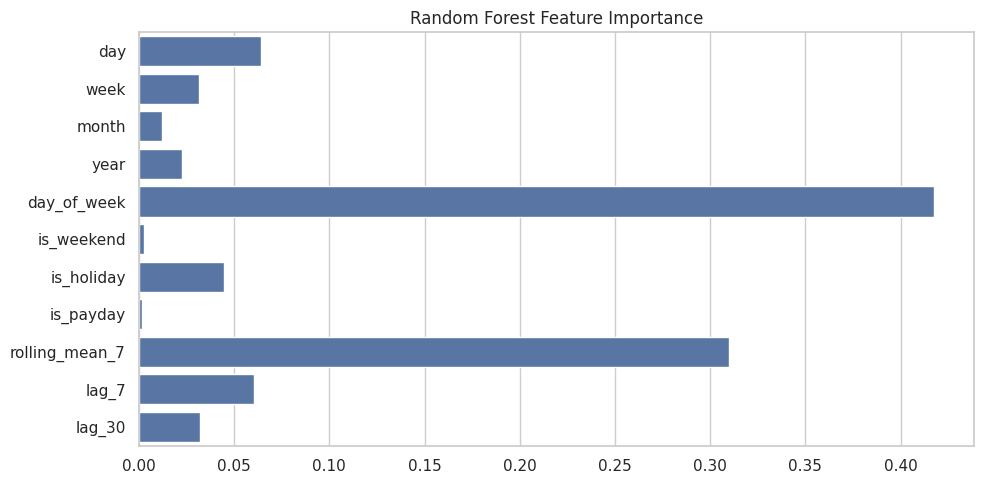

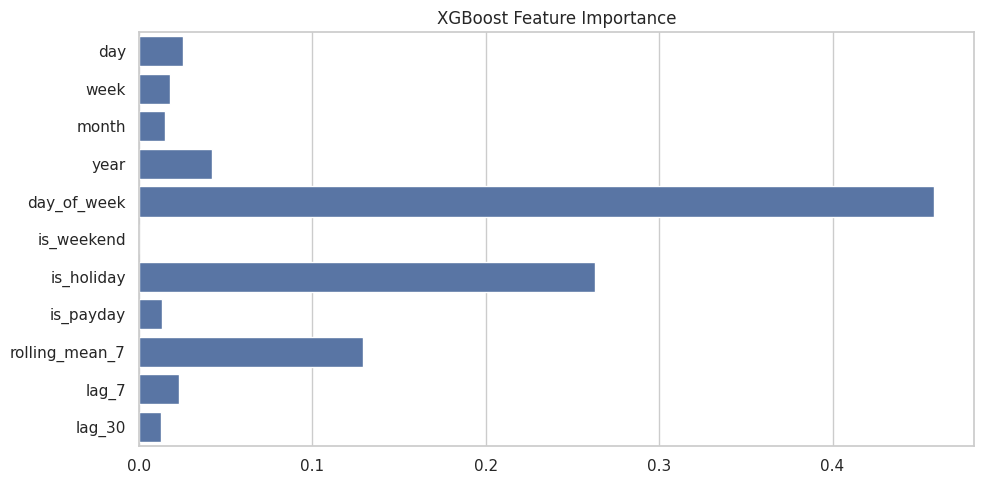

In [39]:
# VISUALIZATION

# 1. Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', marker='o')
for col in ['Naive', 'ARIMA', 'RandomForest', 'XGBoost', 'LSTM', 'Prophet']:
    plt.plot(results_df['Date'], results_df[col], label=col)
plt.title("Actual vs Predicted Sales (All Models)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Error Metrics Comparison
summary_df = pd.DataFrame(results_list).set_index('Model')
summary_df[['RMSE', 'MAPE', 'R2']].plot(kind='bar', figsize=(14, 6), title=' Model Performance Comparison')
plt.ylabel("Metric Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Feature Importance - Random Forest
importances_rf = rf.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=importances_rf, y=features)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# 4. Feature Importance - XGBoost
importances_xgb = xg.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=importances_xgb, y=features)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [40]:
# INTERPRETATION & INSIGHTS
best_model = summary_df['RMSE'].idxmin()
print(f" Best Performing Model: {best_model}")

 Best Performing Model: Random Forest


Business Insights:
- Holidays and promotions significantly impact sales — high importance in RF/XGBoost.
- Oil prices are indirectly influential and should be combined with macroeconomic features for deeper insight.
- Government paydays around 15th & month-end show spikes in demand.
- LSTM and Prophet captured seasonality well, while tree-based models were best for handling nonlinear patterns.